# ML Workflow of model deployment and monitoring for Image Classification

The goal is to deploy and monitor a binary classifier for detect bicycles vs. motorcycles. For the training data CIFAR-100 dataset is used and filtered for only bicycles and motorcycles.

## Steps

1. ETL image data
2. Train using AWS image classification framework
3. Set up a Data Capture Monitor and Deploy the model
4. Set up Lambda Functions to: Generate Data for the endpoint, Get Inference from the endpoint, Report if confidence/probability is acceptable
5. Set up Step Function to orchestrate the workflow


### Loading Libraries



In [2]:
import sagemaker
import os
import requests
import tarfile
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import boto3
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
from sagemaker.model_monitor import DataCaptureConfig
from sagemaker.serializers import IdentitySerializer
from sagemaker import get_execution_role
from zipfile import ZipFile
import base64
import random
import json


### 1. Extract, Transform, Load
The CIFAR dataaset is open source hosted by the University of Toronto at: https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz. We would need to Extract the data, Transform it to a format that is suitable for AWS Image Classification Framework models, and then Load it to S3 for model training. In many ML project, this part could be where a lot of time would be spent. This example could be useful when loading data that is zipped and hosted at a server.

In [3]:
## Get the zipped data from the server and Unzip them

def extract_cifar_data(url, filename="cifar.tar.gz"):
    r = requests.get(url)
    print(url)
    print(r.status_code)
    with open(filename, "wb") as file_context:
        file_context.write(r.content)
    return

extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")   
with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall()

https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
200


The data format is pickle according to [CIFAR website](https://www.cs.toronto.edu/~kriz/cifar.html) and to open them there is a script and instruction available.

In [4]:
with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

### Data Exploration

Before Transforming the data, we need to do some data exploration to understand the format of current data.

In [5]:
index = 0
print("datasets keys:")

print(dataset_train.keys())

example = dataset_train[b'data'][index]
print(example.shape)

datasets keys:
dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
(3072,)


We can see that the data for each sample is in the format of a 3072 vector instead of a 32x32x3 array. Therefore, this is the main transformation of the data that we need to do since Image Classification Framework and models are based on CNN that require 2D images.

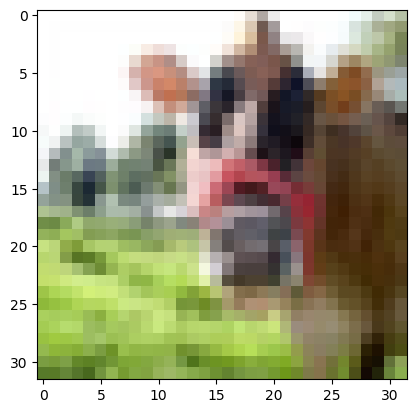

In [6]:
example_image = np.dstack((
    example[0:1024].reshape(32,32),
    example[1024:2048].reshape(32,32),
    example[2048:].reshape(32,32)
))

plt.imshow(example_image)
plt.show()

We also check all the label names and find the label of a sample:

In [7]:
print(dataset_meta[b'fine_label_names'])
example_label = dataset_train[b'fine_labels'][index]

print("Label for the example is {} which means {}".format(example_label, dataset_meta[b'fine_label_names'][example_label]))

[b'apple', b'aquarium_fish', b'baby', b'bear', b'beaver', b'bed', b'bee', b'beetle', b'bicycle', b'bottle', b'bowl', b'boy', b'bridge', b'bus', b'butterfly', b'camel', b'can', b'castle', b'caterpillar', b'cattle', b'chair', b'chimpanzee', b'clock', b'cloud', b'cockroach', b'couch', b'crab', b'crocodile', b'cup', b'dinosaur', b'dolphin', b'elephant', b'flatfish', b'forest', b'fox', b'girl', b'hamster', b'house', b'kangaroo', b'keyboard', b'lamp', b'lawn_mower', b'leopard', b'lion', b'lizard', b'lobster', b'man', b'maple_tree', b'motorcycle', b'mountain', b'mouse', b'mushroom', b'oak_tree', b'orange', b'orchid', b'otter', b'palm_tree', b'pear', b'pickup_truck', b'pine_tree', b'plain', b'plate', b'poppy', b'porcupine', b'possum', b'rabbit', b'raccoon', b'ray', b'road', b'rocket', b'rose', b'sea', b'seal', b'shark', b'shrew', b'skunk', b'skyscraper', b'snail', b'snake', b'spider', b'squirrel', b'streetcar', b'sunflower', b'sweet_pepper', b'table', b'tank', b'telephone', b'television', b'ti

### Filtering the dataset:
to pick only motorcycles and bicycles in the train and test datasets:

In [8]:
# Finding the index for the desired labels
desired_labels = {}
for label_number, label_name in enumerate(dataset_meta[b'fine_label_names']):
    if label_name == b'bicycle' or label_name == b'motorcycle':
        desired_labels[label_number] = 1
    
print(desired_labels)


df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames']))
})
df_train = df_train[(df_train['labels'] == 8) | (df_train['labels'] == 48)]

df_train["filenames"] = df_train["filenames"].apply(lambda x: x.decode("utf-8"))


df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})
df_test = df_test[(df_test['labels'] == 8) | (df_test['labels'] == 48)]

df_test["filenames"] = df_test["filenames"].apply(lambda x: x.decode("utf-8"))

{8: 1, 48: 1}


Now that we now the format and have all the necessary data, we do the transformation for all the samples in the train and test datasets and save the transformed images into train and test folders:





In [9]:
!mkdir ./train
!mkdir ./test

def save_images():
    img = data[b'data'][row["row"]]
    target = np.dstack((
                img[0:1024].reshape(32,32),
                img[1024:2048].reshape(32,32),
                img[2048:].reshape(32,32)
             ))
    plt.imsave(path + row["filenames"], target)
    return

path = './train/'
data = dataset_train
for index, row in df_train.iterrows():
    save_images()

path = './test/'
data = dataset_test
for index, row in df_test.iterrows():
    save_images()

mkdir: cannot create directory ‘./train’: File exists
mkdir: cannot create directory ‘./test’: File exists


After this we can now load all of our transformed data into our S3 bucket so that it is available for our Sagemaker training.

In [10]:
session = sagemaker.Session()
bucket = session.default_bucket()
region = session.boto_region_name
role = sagemaker.get_execution_role()

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/

upload: train/bicycle_s_000017.png to s3://sagemaker-us-east-1-286375333242/train/bicycle_s_000017.png
upload: train/bicycle_s_000043.png to s3://sagemaker-us-east-1-286375333242/train/bicycle_s_000043.png
upload: train/bicycle_s_000035.png to s3://sagemaker-us-east-1-286375333242/train/bicycle_s_000035.png
upload: train/bicycle_s_000124.png to s3://sagemaker-us-east-1-286375333242/train/bicycle_s_000124.png
upload: train/bicycle_s_000021.png to s3://sagemaker-us-east-1-286375333242/train/bicycle_s_000021.png
upload: train/bicycle_s_000180.png to s3://sagemaker-us-east-1-286375333242/train/bicycle_s_000180.png
upload: train/bicycle_s_000038.png to s3://sagemaker-us-east-1-286375333242/train/bicycle_s_000038.png
upload: train/bicycle_s_000231.png to s3://sagemaker-us-east-1-286375333242/train/bicycle_s_000231.png
upload: train/bicycle_s_000051.png to s3://sagemaker-us-east-1-286375333242/train/bicycle_s_000051.png
upload: train/bicycle_s_000159.png to s3://sagemaker-us-east-1-2863753332

### Manifest Files

One of the ways that we can import metadata to Image Classification Frameworks of AWS is by creating manifest files. The format is very simple [.lst format](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html): The first column is image index, the second is the label, and the third is the image file path.


In [11]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )
    
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

boto3.Session().resource('s3').Bucket(bucket).Object('train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(bucket).Object('test.lst').upload_file('./test.lst')

## 2. Model Training

Setting up a training job from available frameworks is the same as previous notebook on this and we follow the same procedure

In [12]:
algo_image = sagemaker.image_uris.retrieve("image-classification", region, "latest")     # Retreiving the image for image-classification framework
s3_output_location = f"s3://{bucket}/models/image_model"                                 # Defining an output path for the model

# Creating an image classifier estimator
img_classifier_model = sagemaker.estimator.Estimator(algo_image, 
                                                     role,
                                                     instance_count = 1,
                                                     instance_type = 'ml.p3.2xlarge',
                                                     output_path = s3_output_location,
                                                     sagemaker_session = session)

# Setting hyper-parameters specific to the estimator algorithm
img_classifier_model.set_hyperparameters(image_shape = "3,28,28",
                                         num_classes = 2,
                                         num_training_samples = len(df_train))

# Setting the data input specific to the image classification
model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train/",
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test.lst",
            content_type="application/x-image"
        )
}                                       

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


After setting all the parameters and arguments for the estimator we can initiate the training job by calling the fit method of the model.

In [13]:
img_classifier_model.fit(inputs = model_inputs, logs = True)

2022-09-07 19:01:36 Starting - Starting the training job...
2022-09-07 19:02:03 Starting - Preparing the instances for trainingProfilerReport-1662577296: InProgress
.........
2022-09-07 19:03:26 Downloading - Downloading input data...
2022-09-07 19:04:07 Training - Downloading the training image..............Docker entrypoint called with argument(s): train
[09/07/2022 19:06:25 INFO 140489717065536] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/image_classification/default-input.json: {'use_pretrained_model': 0, 'num_layers': 152, 'epochs': 30, 'learning_rate': 0.1, 'lr_scheduler_factor': 0.1, 'optimizer': 'sgd', 'momentum': 0, 'weight_decay': 0.0001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps': 1e-08, 'gamma': 0.9, 'mini_batch_size': 32, 'image_shape': '3,224,224', 'precision_dtype': 'float32'}
[09/07/2022 19:06:25 INFO 140489717065536] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {'image_shape': '3,28,28', 'num_classes': '2

## 3. Deploy the model

As shown in the previous notebook, to monitor (capture) the data the goes to the model, we first create a data capture monitor and then create the trained model endpoint.

In [ ]:
data_capture_config = DataCaptureConfig(enable_capture = True,
                                        sampling_percentage = 100,
                                        destination_s3_uri=f"s3://{bucket}/data_capture_img_classifier")

## This can take a moment as it is creating an instance for the endpoint
deployment = img_classifier_model.deploy(initial_instance_count = 1,
                                         instance_type = 'ml.m4.xlarge',
                                         data_capture_config=data_capture_config)

endpoint = deployment.endpoint_name
print("Endpoint Name: {}".format(endpoint))

-----------!Endpoint Name: image-classification-2022-09-07-19-10-57-372


#### Quick test of the endpoint


In [ ]:
deployment.serializer = IdentitySerializer("image/png")

with open("./test/motorcycle_s_001960.png", "rb") as f:
    payload = f.read()
    
inference = deployment.predict(payload)
print("Inference from the endpoint: {}".format(inference))

Inference from the endpoint: b'[0.08544553816318512, 0.9145544767379761]'


## 4. Setting up Lambda Functions

Lamda functions can be defined to form a serverless workflow. They also act as the interface between users and endpoint. We create one Lambda function for each of the tasks below:
- Generate Data: Get the data from the user and transform it into the shape suitable for the endpoint
- Inferance: Send the transformed data to the endpoint and receive the result
- If the confidence of the model, for the classifiction job, was good enough, return the result to the user

For each of these Lambda we write the lambda_function.py in this notebook and create it using SDK method

### 4.1 First lambda function: Generate Data
Writing the lambda_function.py:

In [2]:
%%writefile lambda_function.py

import json
import boto3
import base64
import botocore

s3 = boto3.resource('s3')
def lambda_handler(event, context):
    key = event['s3_key'] 
    bucket = event['s3_bucket']           
    
    try:
        s3.Bucket(bucket).download_file(key, '/tmp/image.png')
    except botocore.exceptions.ClientError as error:
        print("File not accessible")
        raise
    
    with open("/tmp/image.png", "rb") as f:
        image_data = base64.b64encode(f.read())

    print("Event:", event.keys())
    return {
        'statusCode': 200,
        'body': {
            "image_data": image_data,
            "s3_bucket": bucket,
            "s3_key": key,
            "inferences": []
        }
    }

Writing lambda_function.py


Creating the lambda function:

In [8]:
role = get_execution_role()
lambda_client = boto3.client('lambda')

with ZipFile('code.zip', 'w') as f:
    f.write('lambda_function.py')
    
with open('code.zip', 'rb') as f:
    b_code = f.read()

response = lambda_client.create_function(FunctionName='LambdaGenerateData',
                                         Runtime='python3.9',
                                         Handler='lambda_function.lambda_handler',
                                         Code={
                                              'ZipFile': b_code,
                                              },
                                         Description='string',
                                         Timeout=30,
                                         MemorySize=1024,
                                         Publish=True,
                                         PackageType='Zip',
                                         Role="arn:aws:iam::286375333242:role/lambda_full_access")

## 4.2 Second lambda

For this lambda the name of the endpoint should be inserted into the file, so we print it again here:

In [57]:
print(endpoint)

image-classification-2022-09-07-18-17-05-616


Writing lambda_function.py

In [35]:
%%writefile lambda_function.py

import json
import base64
import boto3

runtime = boto3.client('runtime.sagemaker')
ENDPOINT = "image-classification-2022-09-06-13-13-30-012"

def lambda_handler(event, context):
    image = base64.b64decode(event['image_data'])
    reponse = response = runtime.invoke_endpoint(EndpointName=ENDPOINT,
                                                 ContentType='application/x-image',
                                                 Body=image)
    inferences = response['Body'].read().decode('utf-8')
    event["inferences"] = inferences
    return {
        'statusCode': 200,
        'body': {
            "image_data": event['image_data'],
            "s3_bucket": event['s3_bucket'],
            "s3_key": event['s3_key'],
            "inferences": event['inferences'],
        }
    }

Overwriting lambda_function.py


Creating the lambda function:

In [37]:
import boto3
from sagemaker import get_execution_role
from zipfile import ZipFile

role = get_execution_role()

lambda_client = boto3.client('lambda')

with ZipFile('code.zip', 'w') as f:
    f.write('lambda_function.py')
    
with open('code.zip', 'rb') as f:
    b_code = f.read()

    response = lambda_client.create_function(FunctionName='LambdaInfer',
                                             Runtime='python3.9',
                                             Handler='lambda_function.lambda_handler',
                                             Code={
                                                  'ZipFile': b_code,
                                                  },
                                             Description='string',
                                             Timeout=30,
                                             MemorySize=1024,
                                             Publish=True,
                                             PackageType='Zip',
                                             Role="arn:aws:iam::286375333242:role/lambda_full_access")

## 4.3 Third lambda

Writing lambd_function.py

In [38]:
%%writefile lambda_function.py

import json
THRESHOLD = .93
def lambda_handler(event, context):
    inferences = event['inferences'][1:-1].split(',')
    inferences = [float(inference) for inference in inferences]
    meets_threshold = any (inference >= THRESHOLD for inference in inferences)
    if meets_threshold:
        pass
    else:
        raise("THRESHOLD_CONFIDENCE_NOT_MET")

    return {
        'statusCode': 200,
        'body': {
            "image_data": event['image_data'],
            "s3_bucket": event['s3_bucket'],
            "s3_key": event['s3_key'],
            "inferences": event['inferences'],
        }
    }

Overwriting lambda_function.py


Creating the lambda function:

In [39]:
import boto3
from sagemaker import get_execution_role
from zipfile import ZipFile

role = get_execution_role()
lambda_client = boto3.client('lambda')
with ZipFile('code.zip', 'w') as f:
    f.write('lambda_function.py')

    with open('code.zip', 'rb') as f:
    b_code = f.read()

response = lambda_client.create_function(FunctionName='LambdaFilter',
                                         Runtime='python3.9',
                                         Handler='lambda_function.lambda_handler',
                                         Code={
                                              'ZipFile': b_code,
                                              },
                                         Description='string',
                                         Timeout=30,
                                         MemorySize=1024,
                                         Publish=True,
                                         PackageType='Zip',
                                         Role="arn:aws:iam::286375333242:role/lambda_full_access")

## 5. Step Function and model monitoring

We can create a step function in SDK method here to orchestrate the flow of our lambda function but defining and format the necessary JSON file is difficult and not intuitive. Fortunately, AWS has created a Graphical Interface and makes this job very easy. We create a step function and its flow is shown in the github repo.

After creating the step function, we send queries to it and we want to plot some of the results. The cell below helps in creating random queries for step function execuation:


In [59]:
def generate_test_case():
    s3 = boto3.resource('s3')
    objects = s3.Bucket(bucket).objects.filter(Prefix = "test")
    obj = random.choice([x.key for x in objects])
    
    return json.dumps({
                        "image_data": "",
                        "s3_bucket": bucket,
                        "s3_key": obj
                      })

generate_test_case()

'{"image_data": "", "s3_bucket": "sagemaker-us-east-1-286375333242", "s3_key": "test/safety_bike_s_001065.png"}'

# Monitor the model

This section could be on a separate notebook. The goal is to illustrate the monitoring.
We read the data from the DataCapture Monitor that we created from S3 and visualize the result:


In [64]:
from sagemaker.s3 import S3Downloader
!pip install jsonlines
import jsonlines

data_path = "s3://sagemaker-us-east-1-286375333242/data_capture_img_classifier/image-classification-2022-09-06-13-13-30-012/AllTraffic/2022/09/06/16/"
S3Downloader.download(data_path, "captured_data")

# List the file names we downloaded
file_handles = os.listdir("./captured_data")

# Dump all the data into an array
json_data = []
for jsonl in file_handles:
    with jsonlines.open(f"./captured_data/{jsonl}") as f:
        json_data.append(f.read())


In [65]:
def getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    images = obj["captureData"]["endpointInput"]["data"]
    return json.loads(inferences), timestamp, images

Now we can extract the data from each of the source files:

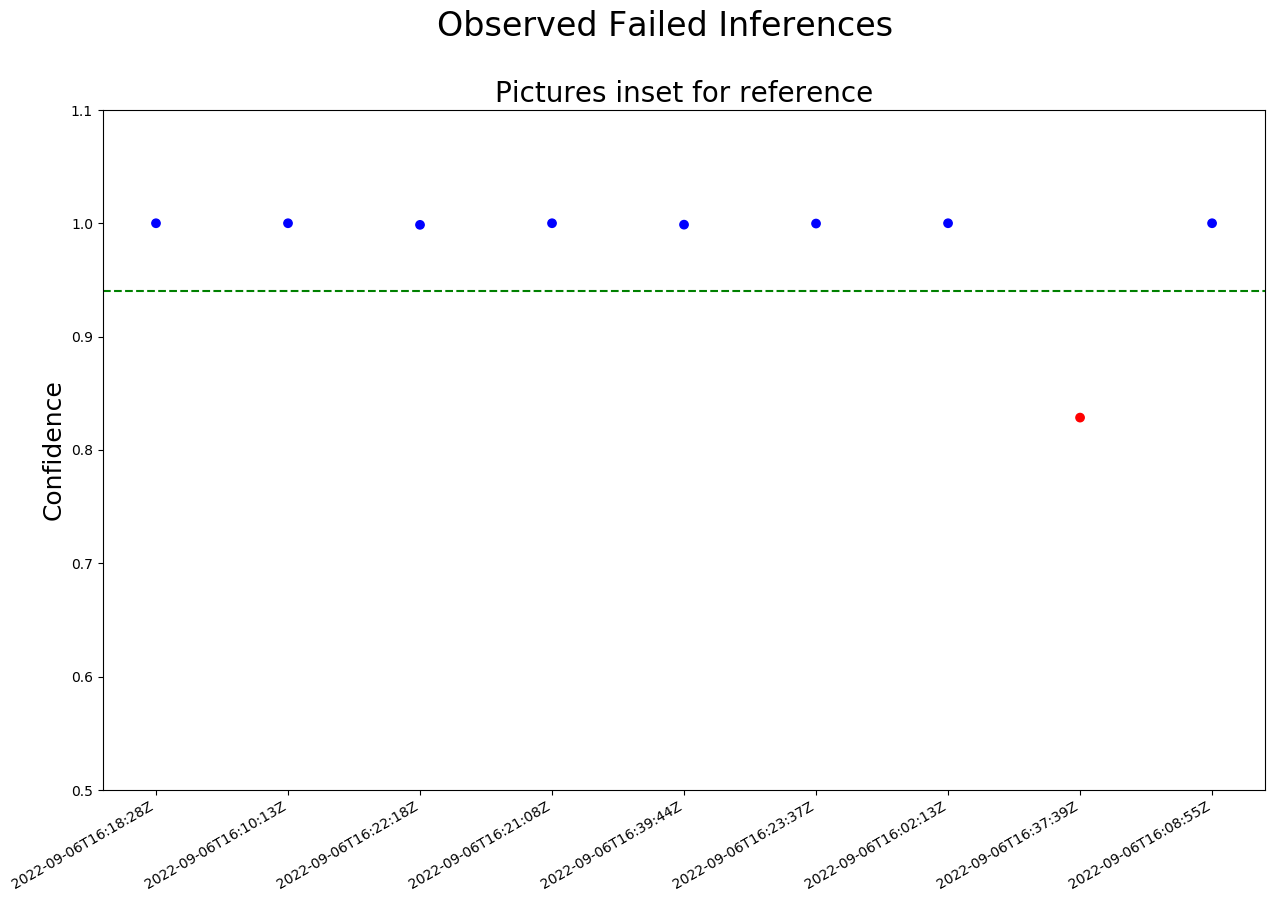

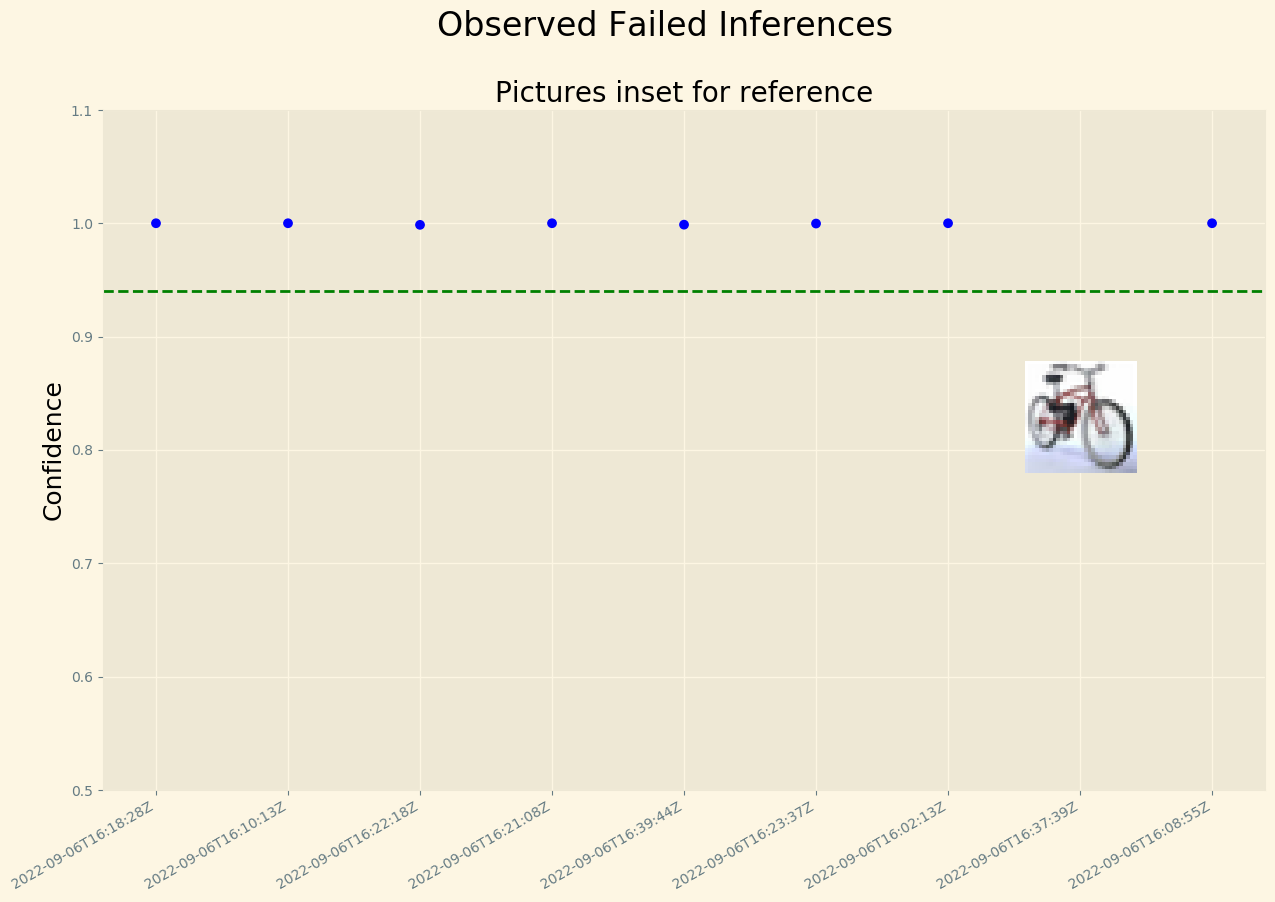

In [68]:
import matplotlib.image as mpimg
import io

x = []
y = []
images = []

for obj in json_data:
    inference, timestamp, image = getter(obj)
    
    if image not in images:
        y.append(max(inference))
        x.append(timestamp)
        images.append(image)

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x, y, c=['r' if k<.94 else 'b' for k in y ])
ax.axhline(y=0.94, color='g', linestyle='--')
plt.ylim(bottom=.50, top=1.1)

# Add labels
plt.ylabel("Confidence", color='black', size=18)
plt.suptitle("Observed Failed Inferences", color='black', size=24)
plt.title("Pictures inset for reference", color='black', size=20)

plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()


from matplotlib.offsetbox import OffsetImage, AnnotationBbox

for x0, y0, image in zip(x, y, images):
    if y0 < 0.94:
        # Convert image to usable format:
        image = base64.b64decode(image)
        image = io.BytesIO(image)
        image = mpimg.imread(image, format='PNG')
        
        im = OffsetImage(image, zoom=2.5)

        ab = AnnotationBbox(im, (x0, y0), frameon=False)
        ax.add_artist(ab)

plt.show()